In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


In [3]:
conn = sqlite3.connect("/home/tirth/Downloads/places.sqlite")

full_data = pd.read_sql_query(
    """
SELECT 
	moz_places.url as url,
    moz_historyvisits.'visit_date' as 'visit_date'
from moz_historyvisits
    join moz_places on moz_places.id = moz_historyvisits.place_id;
    
""",
    conn,
)

# region 1

# full_data = pd.read_sql_query(
#     """
# SELECT
# 	moz_places.url as pl_url,
#     moz_places.visit_count as pl_visit_count,
#     moz_places.frecency as pl_url_frecency,
#     moz_places.last_visit_date as pl_last_visit_date,
#     moz_historyvisits.'from_visit' as 'his_from_visit',
#     moz_historyvisits.'visit_date' as 'his_visit_date',
#     moz_historyvisits.'visit_type' as 'his_visit_type'
# from moz_historyvisits
#     join moz_places on moz_places.id = moz_historyvisits.place_id;

# """,
#     conn,
# )

# endregion

# full_data[full_data["visit_count"] == 0] = 1


In [4]:
full_data.head()


,url,visit_date
0,https://spins.fedoraproject.org/,1652190849558000
1,https://spins.fedoraproject.org/,1654098416035000
2,https://spins.fedoraproject.org/,1656856015277000
3,https://spins.fedoraproject.org/,1666263920924000
4,https://spins.fedoraproject.org/,1668600233996000


In [5]:
import csv
import re

full_data["host"] = full_data["url"].map(
    lambda x: re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x).group(1)
    if re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x) is not None
    else pd.NA
)


full_data.to_csv("full_data.csv", index=False, quoting=csv.QUOTE_ALL)
full_data["host"].isna().sum()


2229

In [6]:
from datetime import datetime

full_data["visit_date_obj"] = full_data["visit_date"].map(
    lambda x: datetime.fromtimestamp(x / 1000000)
)


In [51]:
full_data.drop("url", axis=1, inplace=True)
full_data["visit_count"] = 1

full_data.dropna(axis=0, how="any", inplace=True)
full_data.reset_index(inplace=True, drop=True)

full_data.info()


KeyError: "['url'] not found in axis"

In [8]:
full_data.head()


,visit_date,host,visit_date_obj,visit_count
0,1652190849558000,spins.fedoraproject.org,2022-05-10 19:24:09.558,1
1,1654098416035000,spins.fedoraproject.org,2022-06-01 21:16:56.035,1
2,1656856015277000,spins.fedoraproject.org,2022-07-03 19:16:55.277,1
3,1666263920924000,spins.fedoraproject.org,2022-10-20 16:35:20.924,1
4,1668600233996000,spins.fedoraproject.org,2022-11-16 17:33:53.996,1


In [9]:
def get_TOD(hour):
    if hour >= 5 and hour < 11:
        return "morning"
    elif hour >= 11 and hour < 17:
        return "afternoon"
    elif hour >= 17 and hour < 23:
        return "evening"
    else:
        return "night"


full_data["visit_TOD"] = full_data["visit_date_obj"].map(
    lambda x: get_TOD(x.hour).capitalize()
)

full_data.head()


,visit_date,host,visit_date_obj,visit_count,visit_TOD
0,1652190849558000,spins.fedoraproject.org,2022-05-10 19:24:09.558,1,Evening
1,1654098416035000,spins.fedoraproject.org,2022-06-01 21:16:56.035,1,Evening
2,1656856015277000,spins.fedoraproject.org,2022-07-03 19:16:55.277,1,Evening
3,1666263920924000,spins.fedoraproject.org,2022-10-20 16:35:20.924,1,Afternoon
4,1668600233996000,spins.fedoraproject.org,2022-11-16 17:33:53.996,1,Evening


In [10]:
full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66210 entries, 0 to 66209
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   visit_date      66210 non-null  int64         
 1   host            66210 non-null  object        
 2   visit_date_obj  66210 non-null  datetime64[ns]
 3   visit_count     66210 non-null  int64         
 4   visit_TOD       66210 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 2.5+ MB


In [11]:
def create_datetime_list(x):
    return list(x)


modified_data = (
    full_data.groupby(
        ["host", "visit_TOD"],
        group_keys=False,
    )
    .agg(
        {
            "visit_count": "sum",
            "visit_date_obj": create_datetime_list,
            "visit_date": create_datetime_list,
        }
    )
    .reset_index()
)

modified_data.head()


,host,visit_TOD,visit_count,visit_date_obj,visit_date
0,0.0.7.231,Morning,1,[2023-06-21 10:28:31.729402],[1687323511729402]
1,10.0.0.1:4100,Afternoon,1715,"[2023-02-13 12:18:57.584000, 2023-03-13 12:12:...","[1676270937584000, 1678689757058000, 167869137..."
2,10.0.0.1:4100,Evening,1,[2023-09-29 18:25:00.609477],[1695992100609477]
3,10.0.0.1:4100,Morning,236,"[2023-03-23 09:47:42.522000, 2023-03-23 10:19:...","[1679545062522000, 1679546963118000, 167954710..."
4,10.9.153.35,Evening,37,"[2023-05-14 17:49:28.090000, 2023-05-14 17:50:...","[1684066768090000, 1684066856510000, 168406680..."


In [12]:
modified_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207 entries, 0 to 3206
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   host            3207 non-null   object
 1   visit_TOD       3207 non-null   object
 2   visit_count     3207 non-null   int64 
 3   visit_date_obj  3207 non-null   object
 4   visit_date      3207 non-null   object
dtypes: int64(1), object(4)
memory usage: 125.4+ KB


In [14]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


In [50]:
dbscan = DBSCAN(eps=30000000, min_samples=5)

dbs = dbscan.fit_predict(full_data[["visit_date"]])

dbs.sort()

# count number of -1
(dbs[dbs == -1].size / dbs.size)


0.5812566077631778

In [14]:
top_30_data = modified_data.sort_values(by="visit_count", ascending=False).iloc[21:41]

top_30_data.head()


,host,visit_TOD,visit_count,visit_date_obj,visit_date
2375,twitter.com,Night,335,"[2023-05-28 02:08:49.442000, 2023-06-10 00:00:...","[1685219929442000, 1686335417683147, 168676447..."
215,app.simplelogin.io,Evening,331,"[2023-04-14 18:17:27.186000, 2023-04-14 20:07:...","[1681476447186000, 1681483068931000, 168148314..."
1276,hub.docker.com,Evening,325,"[2023-06-03 21:29:46.300000, 2023-06-03 17:07:...","[1685807986300000, 1685792250323000, 168579216..."
73,access.redhat.com,Evening,322,"[2023-06-08 18:22:29.904734, 2023-06-01 17:24:...","[1686228749904734, 1685620450645000, 168562062..."
711,developers.flow.com,Evening,317,"[2023-07-03 18:16:21.455791, 2023-07-03 22:54:...","[1688388381455791, 1688405043664794, 168822565..."


/home/tirth/College/Sem-5/FDS/FDS-Prac/venv/lib64/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


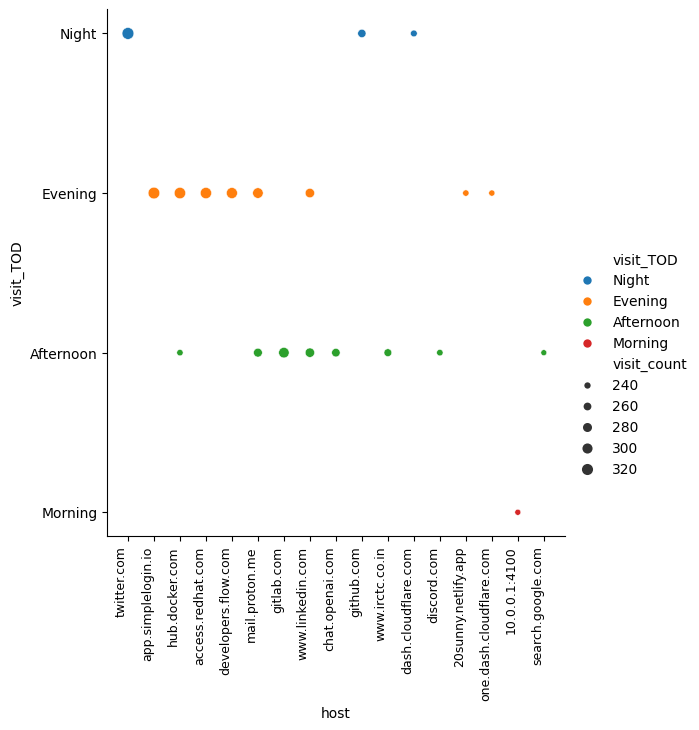

In [16]:
ax = sns.relplot(
    x="host",
    y="visit_TOD",
    data=top_30_data,
    hue="visit_TOD",
    size="visit_count",
    height=6,
    aspect=1,
    legend="brief",
)

ax.set_xticklabels(rotation=90, ha="right", fontsize=9, y=0)

plt.show()
